In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from controller import Controller

In [2]:
# the 0 delfector was horizontal 
deflector_df = pd.read_csv(os.path.join("data", "deflector_data.csv"))
stationary_wheel_df = pd.read_csv(os.path.join("data", "stationary_wheel_data.csv"))
moving_wheel_df = pd.read_csv(os.path.join("data", "moving_wheel.csv"))
deflector_df.head()

,First Lap,Second Lap,Deflector8
0,1.021828,2.106921,0
1,1.056014,2.273317,3
2,1.039654,2.297307,0
3,1.225204,2.573824,2
4,1.078814,2.402853,3


In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def get_metrics(data, column, ranges=[2, 4, 8]):
    metrics_arr = []
    conf_matrix_arr = []
    for s in ranges:
        metrics = {
        'Accuracy': accuracy_score(data[f'{column}{s}'], data[f'Prediction{s}']),
        'Precision': precision_score(data[f'{column}{s}'], data[f'Prediction{s}'], average='macro'),
        'Recall': recall_score(data[f'{column}{s}'], data[f'Prediction{s}'], average='macro'),
        'F1 Score': f1_score(data[f'{column}{s}'], data[f'Prediction{s}'], average='macro')
        }
        conf_matrix = confusion_matrix(data[f'{column}{s}'], data[f'Prediction{s}'])

        metrics_arr.append(metrics)
        conf_matrix_arr.append(conf_matrix)
    return metrics_arr, conf_matrix_arr


def plot_metrics_and_conf_matrices(metrics_arr, conf_matrix_arr, sector_counts, title):
    num_metrics = len(metrics_arr)
    fig, axes = plt.subplots(nrows=num_metrics, ncols=2, figsize=(12, num_metrics * 4))

    for i in range(num_metrics):
        # Plotting bar chart for metrics
        names = list(metrics_arr[i].keys())
        values = list(metrics_arr[i].values())
        axes[i, 0].bar(names, values, color='skyblue')
        axes[i, 0].set_xlabel('Metrics')
        axes[i, 0].set_ylabel('Values')
        axes[i, 0].set_title(f'Metrics for {title} ({sector_counts[i]} Sectors)')

        # Plotting confusion matrix
        sns.heatmap(conf_matrix_arr[i], annot=True, fmt='d', cmap='RdBu', ax=axes[i, 1])
        axes[i, 1].set_title(f'Confusion Matrix ({sector_counts[i]} Sectors)')
        axes[i, 1].set_xlabel('Predicted')
        axes[i, 1].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()
    
def plot_distributions(data, column, sectors=[2, 4, 8]):
    plt.figure(figsize=(15, 10))

    # Plot for actual values
    for i, s in enumerate(sectors):
        plt.subplot(2, len(sectors), i + 1)
        sns.histplot(data[f'{column}{s}'], kde=True, color="blue", label=f'{column}{s}')
        plt.title(f'Distribution of {column}{s}')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()

    # Plot for predicted values
    for i, s in enumerate(sectors):
        plt.subplot(2, len(sectors), len(sectors) + i + 1)
        sns.histplot(data[f'Prediction{s}'], kde=True, color="red", label=f'Prediction{s}')
        plt.title(f'Distribution of Prediction{s}')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()

    plt.tight_layout()
    plt.show()
    
def add_predictions(data, column, n=8, wheel=False):
    controller = Controller(n, connected=False)
    if not wheel:
        f = lambda x: controller.debug([x['First Lap'], x['Second Lap']])
    else:
        f = lambda x: controller.debug([x['First Lap'], x['Second Lap'], x['Wheel Lap']])
    if n == 8:
        data[f'{column}4'] = data[f'{column}8'] // 2
        data[f'{column}2'] = data[f'{column}4'] // 2
        data[f'Prediction8'] = data.apply(f, axis=1)
        data[f'Prediction4'] = data[f'Prediction8'] // 2
        data[f'Prediction2'] = data[f'Prediction4'] // 2
    else:
        data[f'{column}2'] = data[f'{column}4'] // 2
        data[f'Prediction4'] = data.apply(f, axis=1)
        data[f'Prediction2'] = data[f'Prediction4'] // 2
    
    return data

# Deflectors

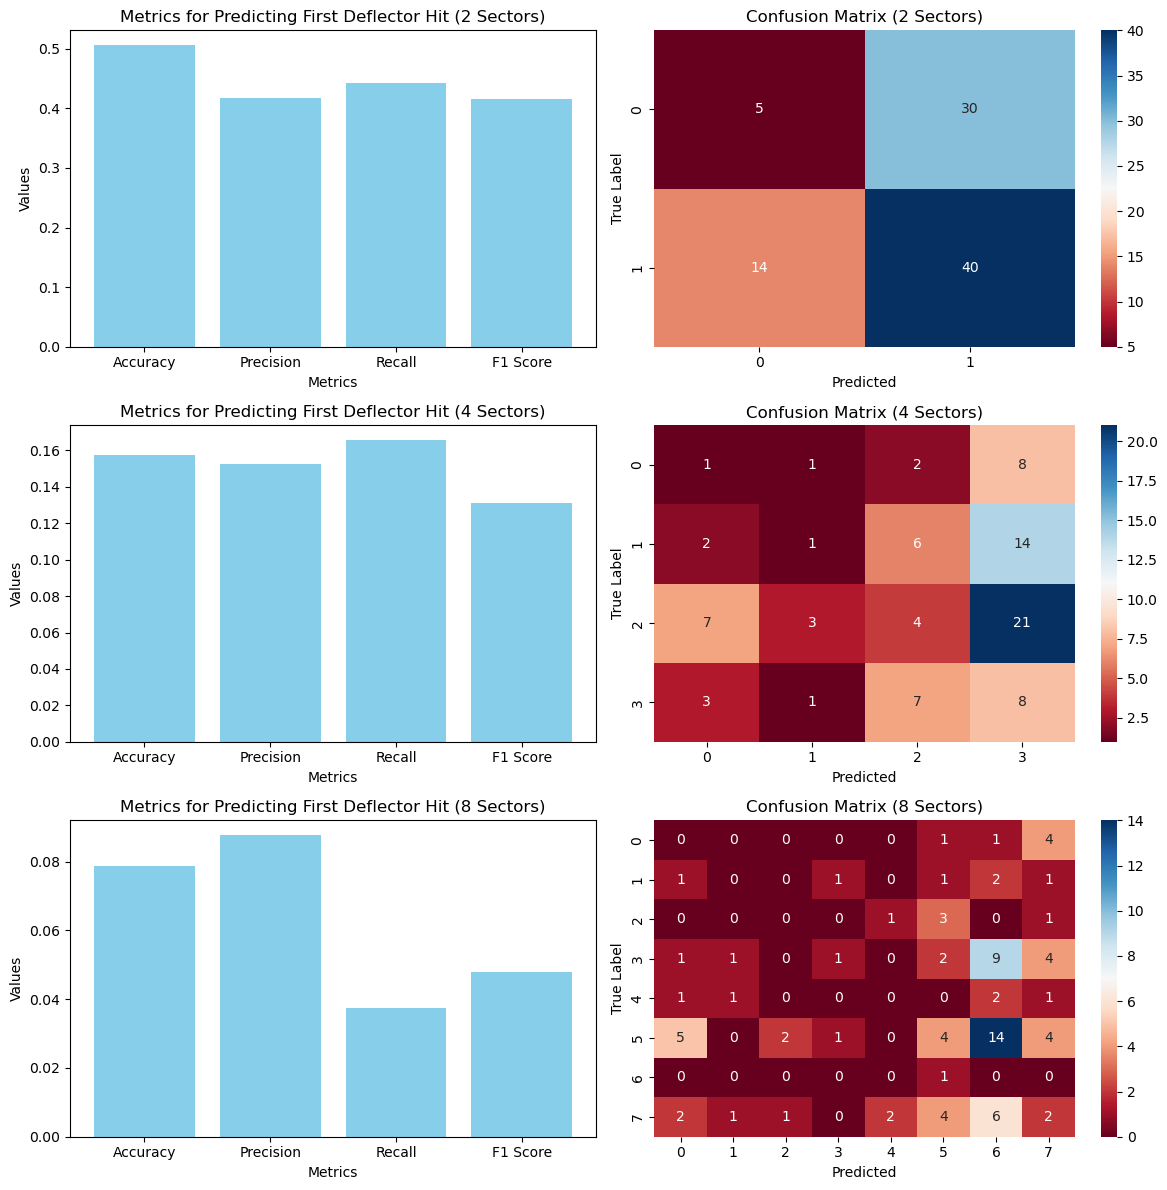

In [4]:
title = "Predicting First Deflector Hit"
deflector_df = add_predictions(deflector_df, 'Deflector')
metrics, conf_matrices = get_metrics(deflector_df, 'Deflector')
plot_metrics_and_conf_matrices(metrics, conf_matrices, [2, 4, 8], title)

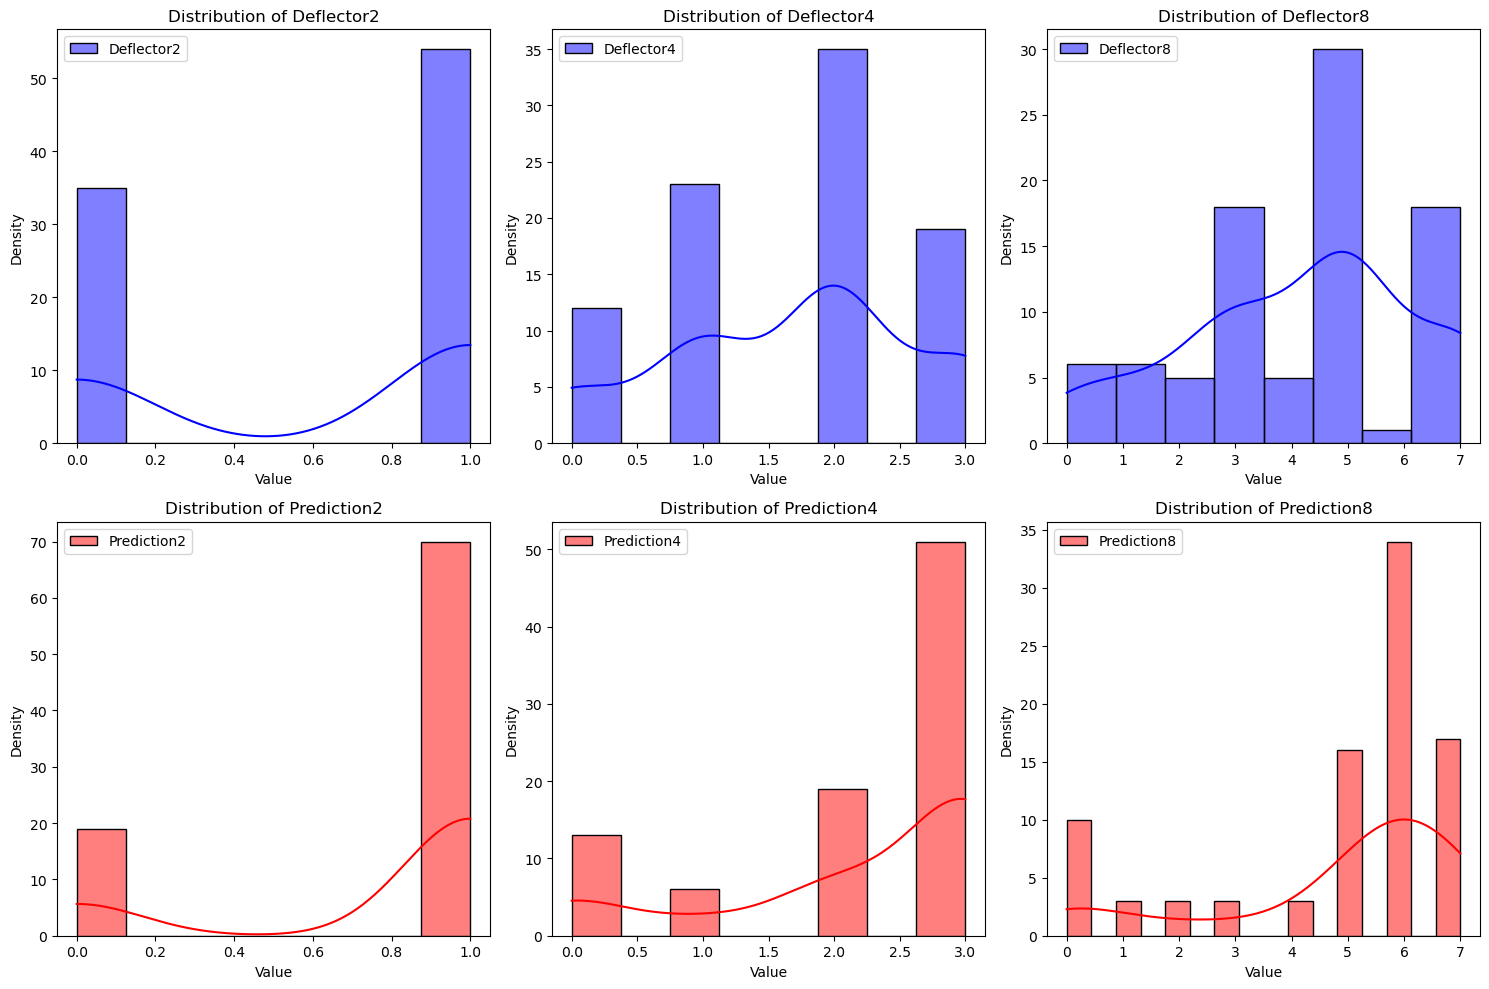

In [5]:
plot_distributions(deflector_df, 'Deflector')

# Stationary Wheel

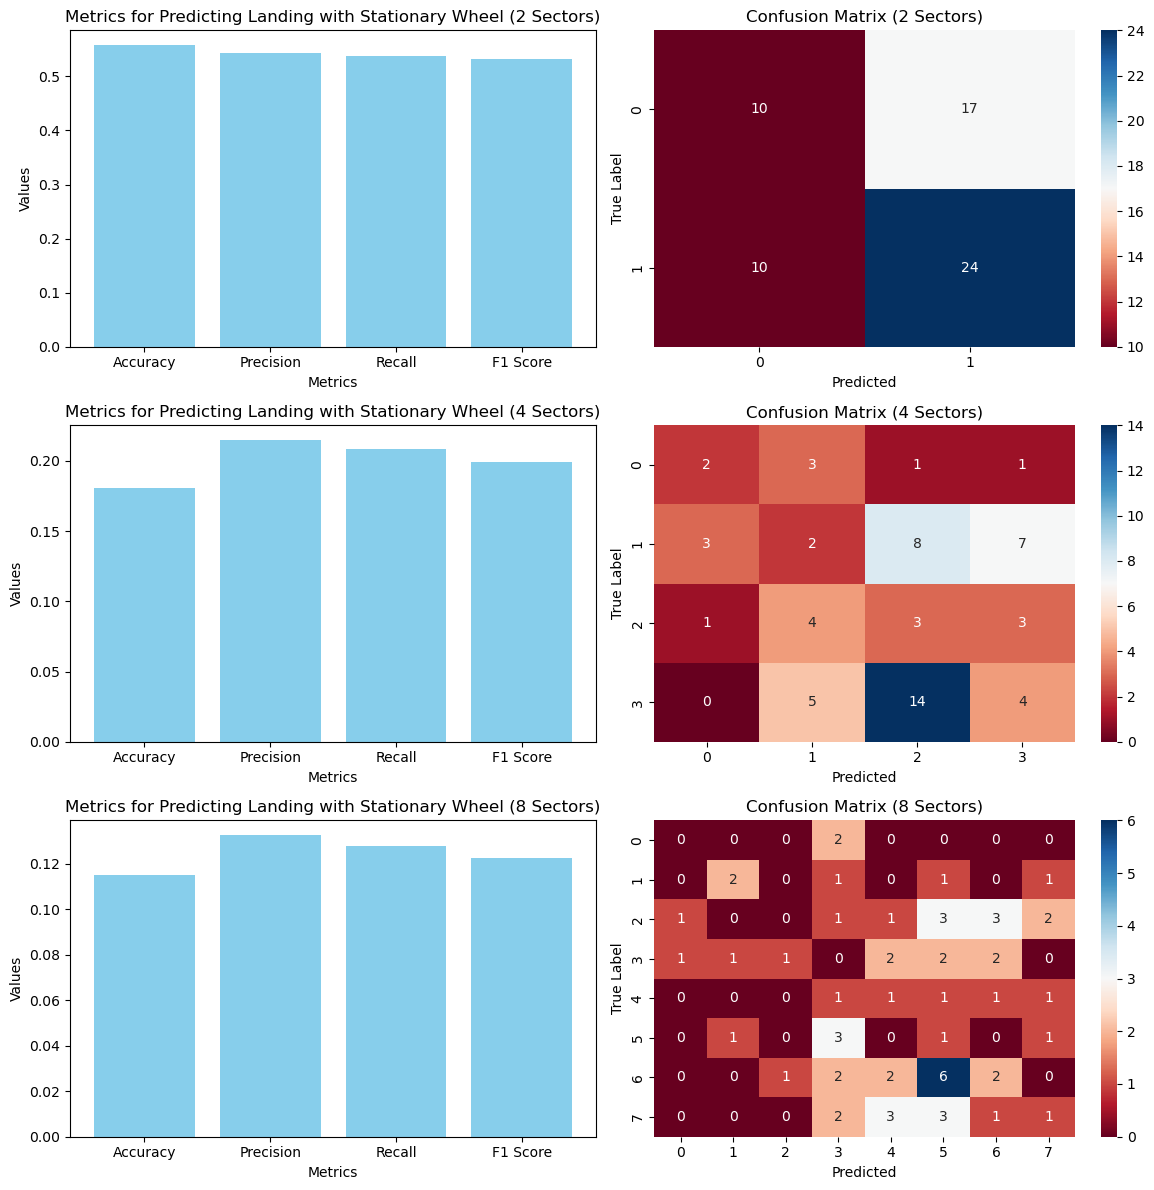

In [6]:
title = "Predicting Landing with Stationary Wheel"
stationary_wheel_df = add_predictions(stationary_wheel_df, 'Sector')
metrics, conf_matrices = get_metrics(stationary_wheel_df, 'Sector')
plot_metrics_and_conf_matrices(metrics, conf_matrices, [2, 4, 8], title)

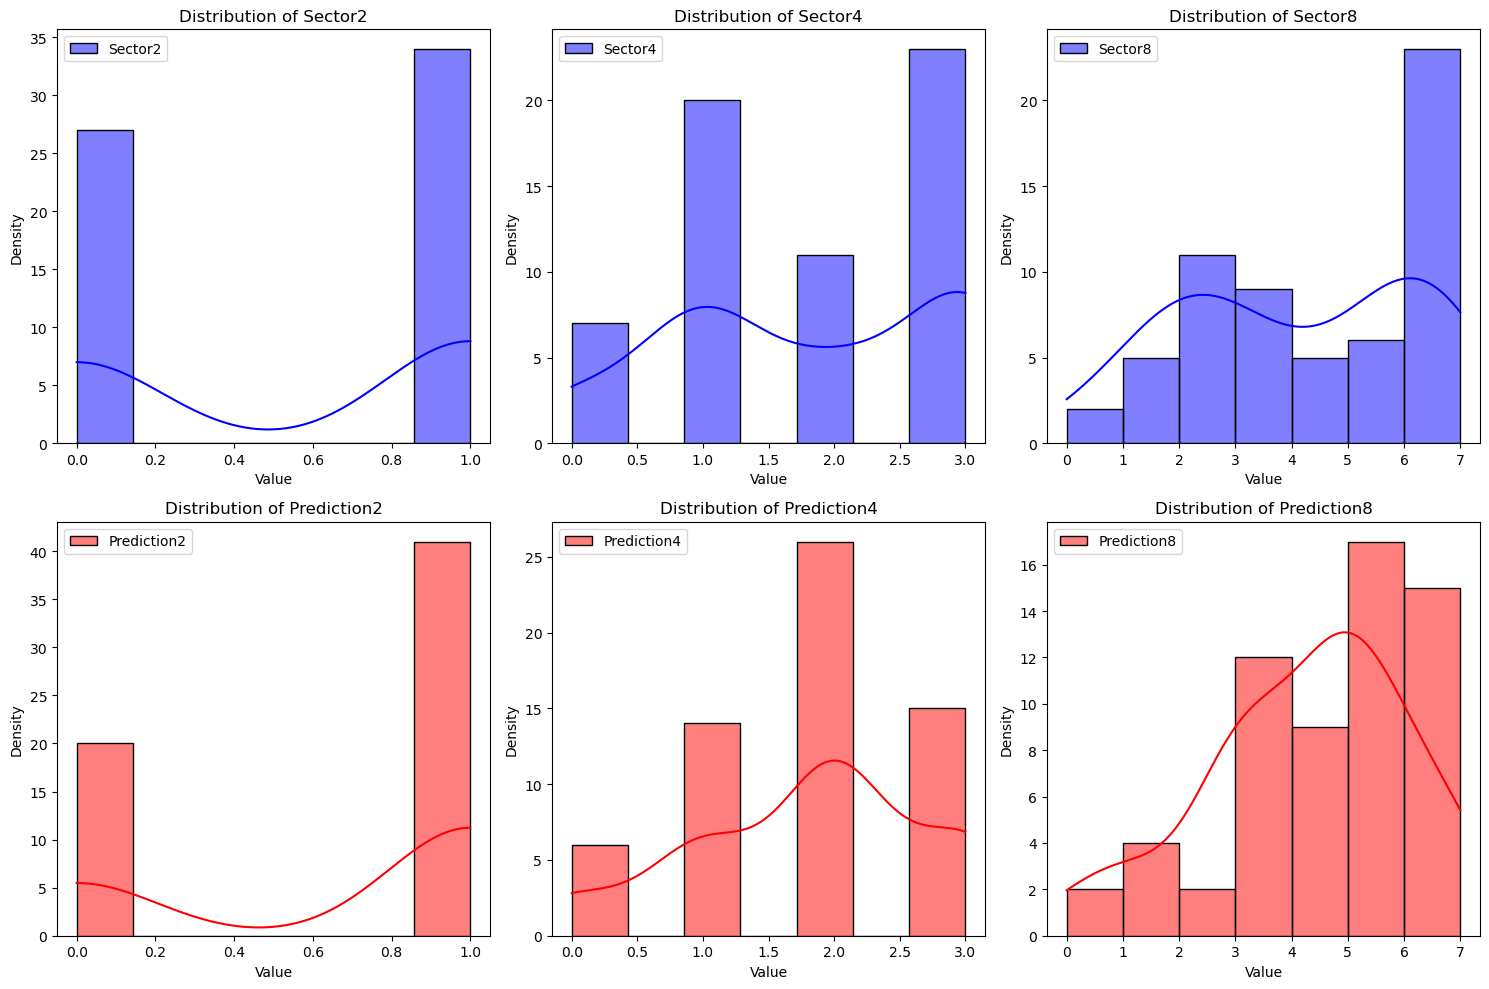

In [7]:
plot_distributions(stationary_wheel_df, 'Sector')

# Moving Wheel

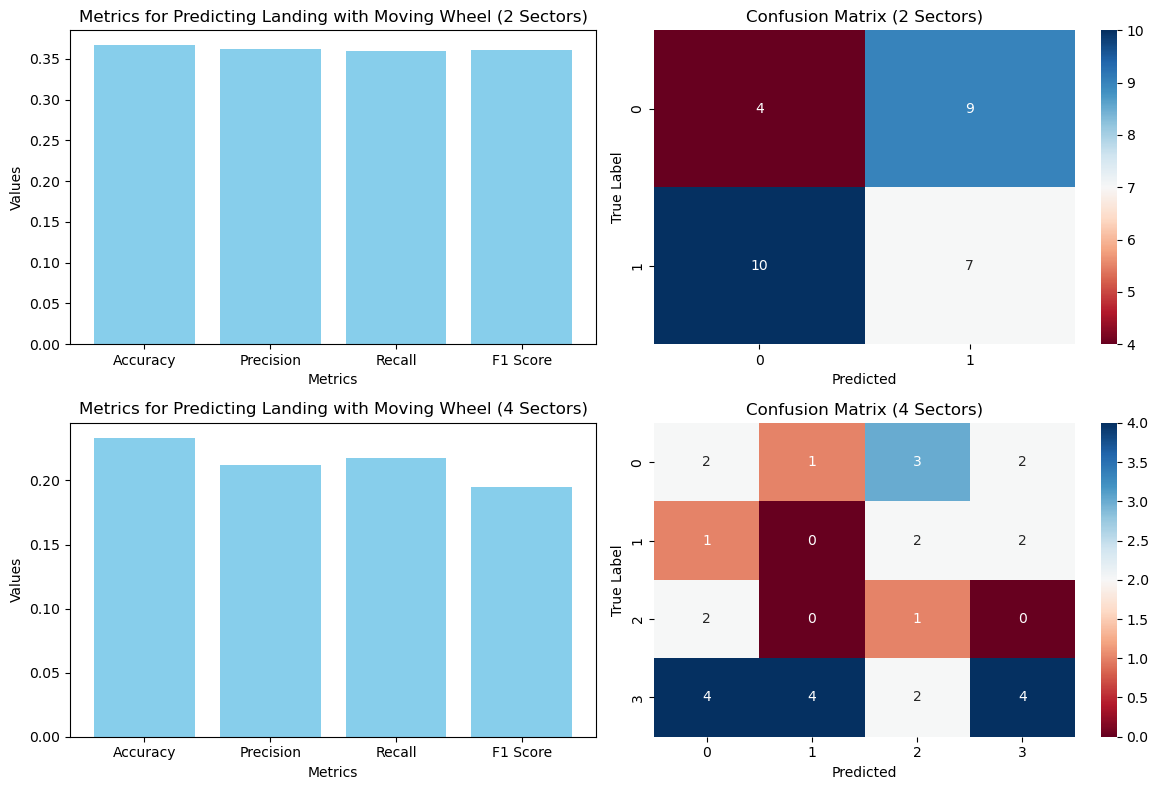

In [8]:
title = "Predicting Landing with Moving Wheel"
moving_wheel_df = add_predictions(moving_wheel_df, 'Sector', n=4, wheel=True)
metrics, conf_matrices = get_metrics(moving_wheel_df, 'Sector', [2, 4])
plot_metrics_and_conf_matrices(metrics, conf_matrices, [2, 4], title)